# 如何在Colab上使用Webcam並運行OpenCV自定義影像處理函式

作者： Jack OmniXRI, 2022/09/07

本範列程式共提供兩種模式：  

**模式一：**使用網路攝影機連續取像並顯示，按下取像鍵後才使用OpenCV進行自定義影像處理及顯示結果。

**模式二：**使用網路攝影機連續取像並顯示，在取像過程同時執行OpenCV自定義影像處理及顯示結果。

In [1]:
# 導入工作必要函式庫
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

## 轉換JavaScript影像物件變成OpenCV格式影像函式

輸入參數：  
js_reply : JavaScript物件，內含從網路攝影像取得之影像  

回返結果:  
img : OpenCV BGR格式之影像  

In [2]:
def js_to_image(js_reply):
  # 解碼成 base64 格式影像
  image_bytes = b64decode(js_reply.split(',')[1])
  # 轉換影像變成 Numpy 格式
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # 解碼 Numpy格式到 OpenCV BGR 影像格式
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

## 自定義OpenCV影像處理函式

可自行加入任意處理OpenCV函式，這裡僅使用一個很簡單的影像色彩反轉為例。  
註：JavaScript預設取得及顯示彩色影像格式為RGB，若使用BGR格式就會產生色彩反轉。  

輸入參數：  
img : OpenCV BGR 格式之輸入影像

回返結果:  
bgr : OpenCV BGR 格式之輸出影像  


In [3]:
def img_process(img):

    bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    return bgr

## Google Colab 網路攝影機取像函式

本函式由Colab左側選單中「程式碼片段」新增「Camera Capture」而得。  

預設呼叫後會產生一個「Capture」按鍵和一個視窗顯示網路攝影機(Webcam)目前取得的連續影像。  

按下「Capture」鍵取得影像後，可使用OpenCV來進行任意影像處理及繪製線、框、文字到影像上，再顯示結果。    

In [4]:
#from IPython.display import display, Javascript
#from google.colab.output import eval_js
#from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # 取得JavaScript產生的影像物件
  data = eval_js('takePhoto({})'.format(quality))

  # 取得影像並加入自定義之OpenCV影像處理程式
  img = js_to_image(data)
  result_img = img_process(img)

  ## 將 JavaScript 取得的影像解碼成 base64 格式
  #binary = b64decode(data.split(',')[1])

  ## 將檔案寫入名為 filename 的檔案中
  #with open(filename, 'wb') as f:
  #  f.write(binary)
  #return filename

  # 可改用 OpenCV imwrite() 函式取代原有檔案寫入動作，可省去轉換 base64 格式動作
  cv2.imwrite("original.jpg", img) #
  cv2.imwrite(filename, result_img)
  return filename

## 等待網路攝影機取像後進行影像處理及顯示結果


按下「Capture」會結束程式並將最後一張影像存入檔案「photo.jpg」中，此為預設檔名亦可於呼叫時另行指定。  

同時會執行自定義影像處理函式，並顯示原始及處理後影像內容。  

<IPython.core.display.Javascript object>

Original Image : original.jpg


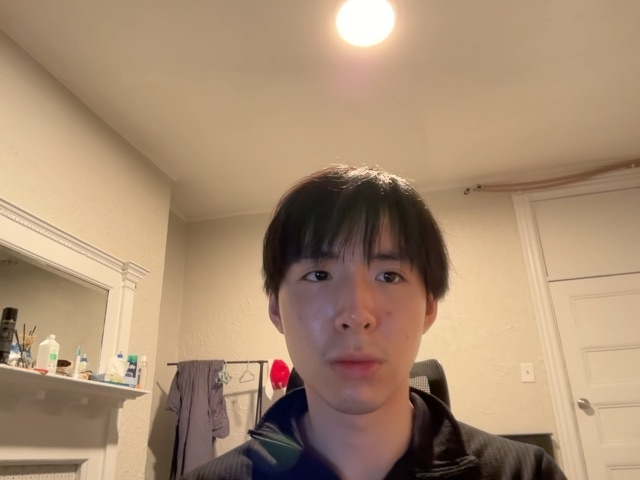

Processed Image : photo.jpg


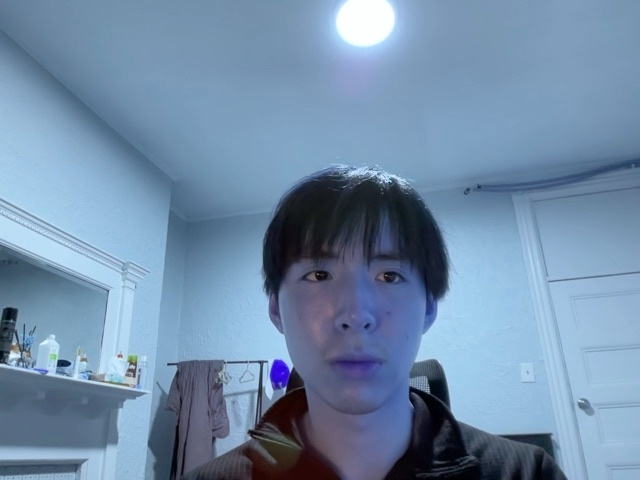

In [5]:
#from IPython.display import Image
try:
  # 啟動網路攝影機連續取像，按下「Capture」後，取得靜態影像，經自定義影像處理後並顯示，預設存檔檔名 photo.jpg
  result_filename = take_photo()

  # 顯示網路攝影機取得之原始影像
  original_filename = 'original.jpg'
  print('Original Image : {}'.format(original_filename))
  display(Image(original_filename))

  # 顯示影像處理後之結果影像
  print('Processed Image : {}'.format(result_filename))
  display(Image(result_filename))

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**透過以上程式會發現，連續取像過程並不會執行自定義影像處理，只有最後按下「Capture」鍵後才會執行及顯示自定義影像處理函式，所以上述作法只適合靜態結果輸出。**  

接著說明如何在網路攝影機取像過程中就直接執行自定義影像處理的方式。  

由於Colab是雲端服務，所以本地端網路攝影機取得的影像要先上傳，再透過網頁元件顯示獲取的影像，收到後才能再提供給其它程式（如OpenCV, PIL...)進行處理分析。而計算所得的結果（如線、框、文字）需要畫在一個具有透明圖層（Alpha Channel)的影像上，即產生一張去背影像，再套疊到下一個擷取到的影格上，而非目前的影格，所以顯示出來的結果會有一個影格的延遲。若遇到被偵測的物件移動較快時，顯示上會有跟不上的情況產生，是正常的。  



## 從網路攝影機取得及顯示連續串流影像相關函式

video_stream() 設定串流影像顯示環境（包含串流影像顯示及上下文字說明區），並啟動網路攝影機連續取像顯示  
removeDom() 移除網頁文件物件模型  
onAnimationFrame() 繪製套疊影像到影格上  
createDom() 建立網頁文件物件模型  
stream_frame() 取得串流影格內容  
video_frame() 取得目前影格內容  

參考資料來源： https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing

In [6]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## 自定義即時影像處理函式

可任意加入自定義OpenCV, PIL影像處理函式，這裡以隨機繪製一個方塊（空心紅框或實心黃方塊）作為範例。

輸入參數：  
img : OpenCV BGR 格式之輸入影像

回返結果:  
bgra : OpenCV BGRA 格式之輸出影像

In [7]:
import random

def realtime_process(img):
   # 產生一個具透明圖層的影像，即 OpenCV BGRA 格式。
   # [:,:,3]即為透明層設定，初始值為0，即為全透明。
   bgra = np.zeros([img.shape[0],img.shape[1],4], dtype=np.uint8)

   # 產生一組隨機值
   sx = random.randrange(100,400,10) # 起始X座標
   sy = random.randrange(100,300,10) # 起始Y座標
   sw = random.randrange(50,200,10) # 方塊寬度
   sh = random.randrange(50,200,10) # 方塊高度
   sc = random.randrange(0,2,1) # 方塊型式及色彩

   if(sc == 0):
       # 隨意在影像上繪製一個紅色空心方框
       bgra = cv2.rectangle(bgra,(sx,sy),(sx+sw,sy+sh),(255,0,0),2)
   else:
       # 隨意在影像上繪製一個黃色實心方框
       bgra = cv2.rectangle(bgra,(sx,sy),(sx+sw,sy+sh),(128,128,0),-1)

   # 將有繪製圖案部份，透明層[3]設為完全不透明(255)
   bgra[:,:,3] = (bgra.max(axis = 2) > 0 ).astype(int) * 255

   return bgra

## 將 OpenCV BGRA 格式影像轉換成可以覆疊回串流影像之base64格式

輸入參數：  
overlap_array : OpenCV BGRA 格式之輸入影像

回返結果:  
overlap_bytes : PIL RGBA 轉 base64 格式之輸出影像

In [8]:
def overlap_to_bytes(overlap_array):
  # 轉換 OpenCV BGRA 輸入格式到 PIL RGBA 格式
  overlap_PIL = PIL.Image.fromarray(overlap_array, 'RGBA')
  # 建立一個 io 緩衝區
  iobuf = io.BytesIO()
  # 將轉換好的 PIL RGBA 格式影像存成帶透明圖層 PNG 格式到 io 緩衝區
  overlap_PIL.save(iobuf, format='png')
  # 轉換成 base64 格式
  overlap_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return overlap_bytes

## 啟動網路攝影機連續取像並執行自定義影像處理程式

執行過程中以滑鼠點擊影像即會中止程式。  

In [9]:
# 啟動網路攝影機開始接收串流影像
video_stream()
# 設定串流影像文字標籤
label_html = 'Capturing...'
# 清空疊合影像內容
overlap_img = ''

# 執行取像、處理循環，執行過程中若於影像上按下滑鼠鍵即會中止程式
while True:
    # 從網路攝影機取得串流影像目前影格
    js_reply = video_frame(label_html, overlap_img)

    # 若無法取得影格則結束循環
    if not js_reply:
        break

    # 將回傳的JavaScript影像物件轉成 OpenCV BGR 格式
    img = js_to_image(js_reply["img"])

    # 呼叫自定義影像即時處理函式
    overlap_array = realtime_process(img)

    # 將覆疊影像轉換成 base64 格式
    overlap_bytes = overlap_to_bytes(overlap_array)

    # 更新覆疊影像到下一個影格
    overlap_img = overlap_bytes

<IPython.core.display.Javascript object>

KeyboardInterrupt: 